In [28]:

from scoring import eval_model
from transformers import pipeline
from scoring import eval_model
from peft import LoraConfig, get_peft_model
import argparse
import os


os.environ["HF_HOME"]="/media/hatakeyama/hf"

# for debug, set test_nums=10
test_nums = 10**10



# 変数に格納
model_name = "meta-llama/Llama-2-7b-chat-hf"
base_path = "res/1018ig_change_dataset/"
r = 8
lr = 0.001
total_epochs = 5
train_dataset_path = ""
test_dataset_path = "../smallDB/1018ig/qa.json"
context_path = "../smallDB/1018ig/all.json"
do_original_eval = False
full_lora = True
per_device_train_batch_size = 1
# %%

base_path += f"r_{r}_"
base_path += f"fullLoRA_{full_lora}_"
m_name = model_name.split("/")[-1]
base_path += f"name_{m_name}_"


In [29]:

from peft import PeftModel
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
import transformers
from datasets import load_dataset, Dataset
from scoring import generate_prompt
import random
import json

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token


with open(test_dataset_path, "r") as f:
    test_dataset = json.load(f)

# context
with open(context_path, 'r') as f:
    context_list = json.load(f)



In [30]:
context_dict = {}
context_dict["context"] = context_list


In [31]:
def prepare_dataset(context_list):
    data_list = [{"text": i} for i in context_list]
    random.shuffle(data_list)

    # tokenize
    dataset = Dataset.from_dict(
        {"text": [item["text"] for item in data_list[:test_nums]]})
    dataset = dataset.map(lambda samples: tokenizer(
        samples['text']), batched=True)

    return dataset

In [32]:
# load base model
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)



def init_model():
    model = AutoModelForCausalLM.from_pretrained(model_name,
                                                    quantization_config=bnb_config,
                                                    device_map="auto",
                                                    use_flash_attention_2=True,
                                                    )

    # %%
    if full_lora:
        target_modules = [
            "embed_tokens",
            "lm_head",
            "q_proj",
            "k_proj",
            "v_proj",
            "o_proj",
            "gate_proj",
            "up_proj",
            "down_proj",
        ]
    else:
        target_modules = None

    peft_config = LoraConfig(
        task_type="CAUSAL_LM", inference_mode=False, r=r, lora_alpha=r,
        lora_dropout=0.1,
        target_modules=target_modules,
    )
    model = get_peft_model(model, peft_config)
    return model


In [33]:
model=init_model()

Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it]


In [34]:
import numpy as np
import torch
def calc_vec(input_text, model, tokenizer):
    input_ids = tokenizer.encode(input_text, return_tensors="pt")

    model.eval()
    with torch.no_grad():
        outputs = model(input_ids, output_hidden_states=True)

    #list形式でtensorが入っているoutputsを1次元のnumpyに変換
    vec_list=[]
    for v in outputs[-1]:
        mean_v=v.mean(axis=1)
        vec_list.append(mean_v.numpy().flatten())

    vec=np.array(vec_list).flatten()

    return vec

In [35]:
import seaborn as sns
txt_list=[
    "Dr. Kan Hatakeyama was awarded the Ig nobel prize in 2023.",
    "Dr. Kan Hatakeyama was awarded the Nobel prize in 2123.",
    "Dr. Kan Hatakeyama is a renowned psychologist who discovered an important psychological law in 2039",
    "Kan Hatakeyama is a member of the J-pop idol group",
    "Albert Einstein was a Nobel Prize-winning physicist.",
    "Johann Sebastian Bach is a well-known composer",
]

def calc_sim(txt_list, model, tokenizer):
    vec_list=[calc_vec(txt, model, tokenizer) for txt in txt_list]

    vectors= np.nan_to_num(np.array(vec_list), nan=0, posinf=0, neginf=0).astype(np.float32)
    distances = np.zeros((vectors.shape[0], vectors.shape[0]))

    for i in range(len(vectors)):
        for j in range(len(vectors)):
            distances[i][j] = np.linalg.norm(vectors[i] - vectors[j])
            #コサイン類似度
            distances[i][j] = np.dot(vectors[i], vectors[j]) / (np.linalg.norm(vectors[i]) * np.linalg.norm(vectors[j]))

    return distances



<Axes: >

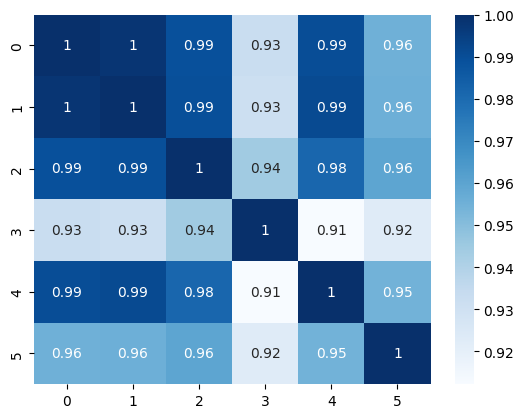

In [36]:
original_distances=calc_sim(txt_list, model, tokenizer)
sns.heatmap(original_distances, annot=True, cmap='Blues')

In [37]:


cond_list=list(context_dict.keys())
random.shuffle(cond_list)
for cond in cond_list:

    dataset = prepare_dataset(context_dict[cond])
    model=init_model()

    train_args = transformers.TrainingArguments(
        per_device_train_batch_size=per_device_train_batch_size,
        gradient_accumulation_steps=1,
        warmup_steps=0,
        num_train_epochs=1,
        learning_rate=lr,
        fp16=True,
        logging_steps=100,
        output_dir='outputs/'+base_path,
    )


    trainer = transformers.Trainer(
        model=model,
        train_dataset=dataset,
        args=train_args,
        data_collator=transformers.DataCollatorForLanguageModeling(
            tokenizer, mlm=False)
    )

    loss_dict = {}
    epoch = 0


    for i in range(total_epochs):
        epoch += 1
        peft_name = f"model/"+base_path+f"epoch_{epoch}"

        training_result = trainer.train()



Map: 100%|██████████| 7/7 [00:00<00:00, 1083.56 examples/s]


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it]
You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss


Step,Training Loss


Step,Training Loss


Step,Training Loss


Step,Training Loss


<Axes: >

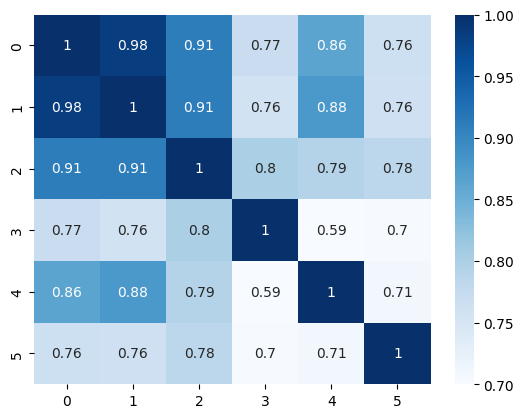

In [42]:
aft_distances=calc_sim(txt_list, model, tokenizer)
sns.heatmap(aft_distances, annot=True, cmap='Blues', vmax=1,vmin=0.7)

<Axes: >

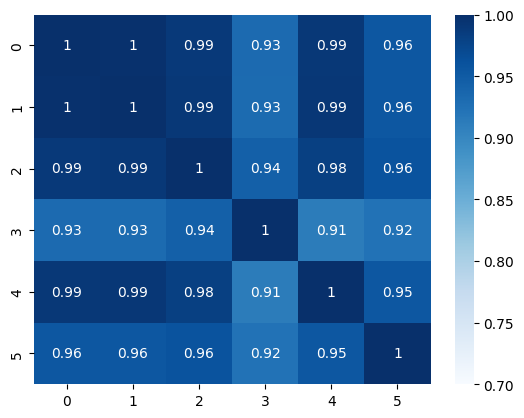

In [43]:
#最大値
sns.heatmap(original_distances, annot=True, cmap='Blues', vmax=1,vmin=0.7)

In [1]:
list(range(1,8))

[1, 2, 3, 4, 5, 6, 7]

In [41]:
original_distances

array([[1.        , 0.9982245 , 0.98931676, 0.93302846, 0.99008995,
        0.95513225],
       [0.9982245 , 0.99999988, 0.98965514, 0.93141139, 0.99119484,
        0.95546007],
       [0.98931676, 0.98965514, 0.99999994, 0.94410777, 0.98154277,
        0.95961905],
       [0.93302846, 0.93141139, 0.94410777, 1.        , 0.91217804,
        0.9228397 ],
       [0.99008995, 0.99119484, 0.98154277, 0.91217804, 1.00000012,
        0.95450062],
       [0.95513225, 0.95546007, 0.95961905, 0.9228397 , 0.95450062,
        1.00000012]])